In [15]:
import lightkurve as lk
import pandas as pd
from astropy.io import fits
import numpy as np

# Metadata

## Načtení

In [27]:
pos = pd.read_csv("positive.csv")
pos

,host,period
0,Kepler-10,0.837


## Seskupení dle systémů

In [28]:
grouped_pos = pos.groupby("host").period.apply(list).to_dict()
grouped_pos

{'Kepler-10': [0.837]}

## Doplnění negativních period

In [29]:
grouped = []

for host in grouped_pos:
    periods = grouped_pos[host]
    
    grouped_item = {"host": host, "periods": []}

    for i in range(len(periods)):
        last = periods[i - 1] if i > 0 else 0
        next = periods[i]
        mid = max((next - last) / 2, 0.5 * 1.13)

        #grouped_item["periods"] += [{"period": mid, "planet": 0}, {"period": next, "planet": 1}]
        grouped_item["periods"] += [{"period": next, "planet": 1}]

    #grouped_item["periods"] += [{"period": periods[-1] * 1.67, "planet": 0}]
    grouped.append(grouped_item)

grouped

[{'host': 'Kepler-10', 'periods': [{'period': 0.837, 'planet': 1}]}]

# Trénovací množina

## Stažení TPS a uložení křivek

In [30]:
lcs = {}

for item in grouped:
    host, periods = item["host"], item["periods"]
    lc_path = f".cache/lc/{host}.fits"

    try:
        lc = lk.read(lc_path)
    except:
        tps = lk.search_targetpixelfile(host, mission="Kepler", exptime="long").download_all()  # limit=15
        lcc = map(lambda tp: tp.to_lightcurve(aperture_mask=tp.pipeline_mask), tps)
        lc = lk.LightCurveCollection(lcc).stitch().flatten(window_length=301).remove_nans()
        lc.to_fits(lc_path)

    lcs[host] = lc

lcs.keys()

dict_keys(['Kepler-10'])

## Hledání period a sestavení lokálních a globálních pohledů

`period` contains 1043775 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


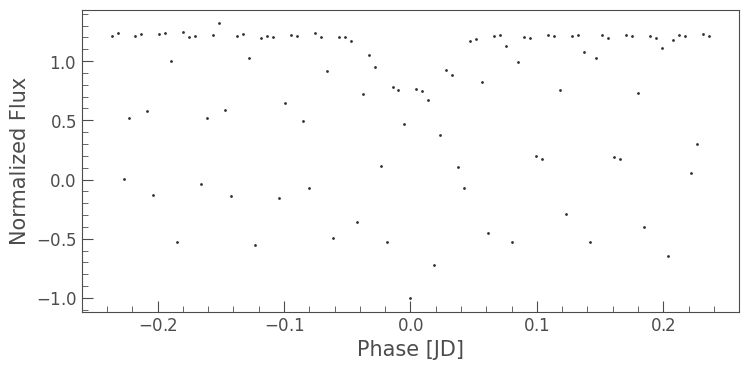

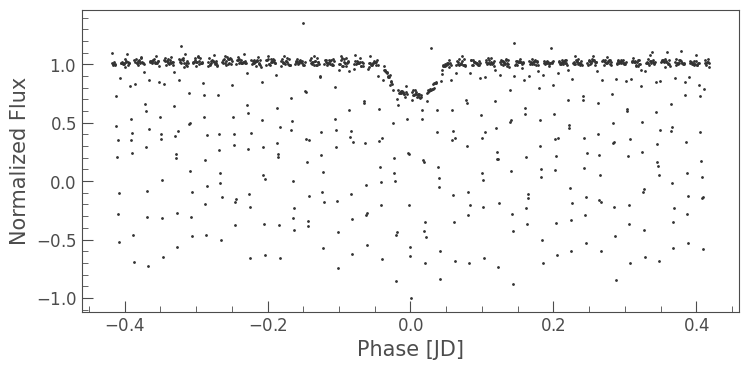

In [31]:
lv_input, gv_input, output = [], [], []

for item in grouped:
    lc = lcs[item["host"]]

    for period in item["periods"]:
        per = period["period"]
        pdg = lc.to_periodogram("bls", period=np.linspace(max(0.5, per * 0.9), per * 1.1, 100000))
        per, dur, t0 = pdg.period_at_max_power.value, pdg.duration_at_max_power.value, pdg.transit_time_at_max_power.value

        fold = lc.fold(per, epoch_time=t0).remove_outliers(sigma=10, sigma_lower=20)

        gv = fold.bin(bins=1001)

        if np.isnan(gv.flux.value).any():
            gv.flux[np.isnan(gv.flux.value)] = np.nanmin(gv.flux.value)
    
        gv = gv.normalize() - 1
        gv = (gv / np.abs(np.nanmin(gv.flux))) * 2.0 + 1
        
        fractional_duration = dur / per
        phase_mask = (fold.phase.value > -4 * fractional_duration) & (fold.phase.value < 4 * fractional_duration)
        lc_zoom = fold[phase_mask]
        lv = lc_zoom.bin(bins=101)

        if np.isnan(lv.flux.value).any():
            lv.flux[np.isnan(lv.flux.value)] = np.nanmin(lv.flux.value)
    
        lv = lv.normalize() - 1
        lv = (lv / np.abs(np.nanmin(lv.flux))) * 2.0 + 1

        lv_input.append(lv.flux.value)
        gv_input.append(gv.flux.value)

        out = np.zeros(2,)
        out[period["planet"]] = 1
        output.append(out)

        if period["planet"]:
            mask = pdg.get_transit_mask(period=per, transit_time=t0, duration=dur)
            masked_lc = lc[~mask]

            lv.scatter()
            gv.scatter()

lv_input, gv_input, output = np.array(lv_input), np.array(gv_input), np.array(output)